In [20]:
# import library and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# load dataset
data = pd.read_csv('data.csv', delimiter=';')

# preprocess

# check if there is missing value
data.isnull().sum()

# encoding categorical variable
# Dropout -> 0, Enrolled -> 1, Graduate -> 1
data['Target'] = data['Target'].map({'Dropout': 0, 'Enrolled': 1, 'Graduate': 1})

# form features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# change column name Nacionality to Nationality
X.rename(columns={'Nacionality': 'Nationality'}, inplace=True)

# change Nationality value 1 to 1, all other to 0
X['Nationality'] = X['Nationality'].apply(lambda x: 1 if x == 1 else 0)

# drop Gender column to avoid discrimination
X = X.drop(['Gender'], axis=1)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split dataset
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [21]:
# use cross validation to evaluate model consistency on X_train_scaled data
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=42)
scores = cross_val_score(svm, X_train_scaled, y_train, cv=10, scoring='accuracy')
print("accuracy mean:", scores.mean(), "accuracy std:", scores.std())

accuracy mean: 0.8680430850978699 accuracy std: 0.010557612394482847


In [22]:
# compare results with unscaled version of data

svm = SVC(kernel='rbf', random_state=42)
scores = cross_val_score(svm, X_train, y_train, cv=10, scoring='accuracy')
print("accuracy mean:", scores.mean(), "accuracy std:", scores.std())

accuracy mean: 0.6877650805844977 accuracy std: 0.001347602307660996


In [30]:
# hyperparameter search for SVM

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_scaled, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test_scaled)
accuracy = grid.score(X_test_scaled, y_test)
print(accuracy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, k

In [31]:
# classification with kernel svm

from sklearn.metrics import confusion_matrix

classifier = SVC(kernel='rbf', C=10, gamma=0.01, random_state=42)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)

# accuracy, precision, recall, f1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("")
print("Confusion Matrix: [TP, FP], [FN, TN]")
print(cm)

Accuracy: 0.8632768361581921
Precision: 0.8522012578616353
Recall: 0.9525483304042179
F1 Score: 0.8995850622406639

Confusion Matrix: [TP, FP], [FN, TN]
[[222  94]
 [ 27 542]]


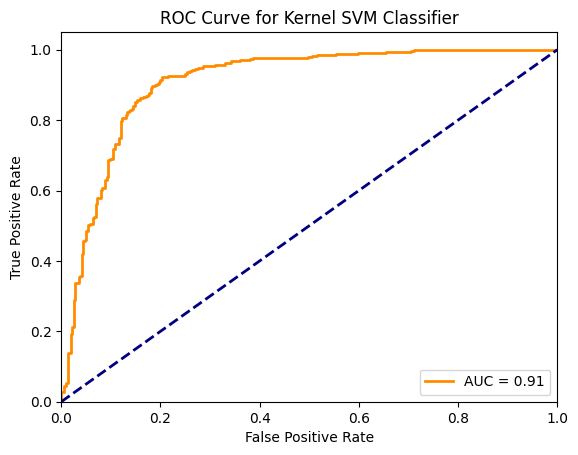

In [32]:
# roc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

X_test_proba = classifier.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, X_test_proba)
# auc
from sklearn.metrics import auc

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve for Kernel SVM Classifier')
plt.legend(loc="lower right")
plt.show()
